In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import folium
import webbrowser
import os
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from keras.models import Sequential
from keras.layers import LSTM, Dense,TimeDistributed, RepeatVector, Bidirectional
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping

In [2]:
#Input Data Constants Configuration
INPUT_STEP = 364  #The number of days of chosen data 
OUTPUT_STEP = 364
TIMESTEPS_IN_SLICE = 24
TIMESTEPS_OUT_SLICE = 24
"""
    INPUT_DIM = 
    OUTPUT_DIM = 
    patience = 50
    batch_size = 64
    epoch_num = 150
    verbose_num = 11
"""
PARAMETERS = [
    'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO',
]
SELECTED_PARAMETERS = PARAMETERS 

In [3]:
#Extract data from one specific station '1147A' station
def get_raw_data(input_data):
    data = input_data.loc[:,['date','hour','type','1147A']]
    return data

In [4]:
#Put all the pollution data into one dataframe
start = datetime(2019, 1, 2)
end = datetime(2019, 12, 31)
day_range = pd.date_range(start, end, freq = 'D')
df1 = pd.read_csv(f'china_sites_20190101.csv') 
df_sum = df1

for i in day_range:
    day = datetime.strftime(i, '%Y%m%d')
    print(day)
    df = pd.read_csv(f'china_sites_{day}.csv') 
    df_sum = pd.concat([df_sum,df])
df=get_raw_data(df_sum)

20190102
20190103
20190104
20190105
20190106
20190107
20190108
20190109
20190110
20190111
20190112
20190113
20190114
20190115
20190116
20190117
20190118
20190119
20190120
20190121
20190122
20190123
20190124
20190125
20190126
20190127
20190128
20190129
20190130
20190131
20190201
20190202
20190203
20190204
20190205
20190206
20190207
20190208
20190209
20190210
20190211
20190212
20190213
20190214
20190215
20190216
20190217
20190218
20190219
20190220
20190221
20190222
20190223
20190224
20190225
20190226
20190227
20190228
20190301
20190302
20190303
20190304
20190305
20190306
20190307
20190308
20190309
20190310
20190311
20190312
20190313
20190314
20190315
20190316
20190317
20190318
20190319
20190320
20190321
20190322
20190323
20190324
20190325
20190326
20190327
20190328
20190329
20190330
20190331
20190401
20190402
20190403
20190404
20190405
20190406
20190407
20190408
20190409
20190410
20190411
20190412
20190413
20190414
20190415
20190416
20190417
20190418
20190419
20190420
20190421
20190422
2

In [5]:
df

,date,hour,type,1147A
0,20190101,0,AQI,27.0
1,20190101,0,PM2.5,17.0
2,20190101,0,PM2.5_24h,28.0
3,20190101,0,PM10,27.0
4,20190101,0,PM10_24h,36.0
...,...,...,...,...
355,20191231,23,O3_24h,63.0
356,20191231,23,O3_8h,58.0
357,20191231,23,O3_8h_24h,59.0
358,20191231,23,CO,0.4


In [6]:
#Combine the date column and the hour column to time column and set it to the index
df['time'] = df.apply(lambda x: str(x['date']) + '/' +str(x['hour']),axis=1)
time=[i for i in df['time']]
df['time']=pd.to_datetime(time,format='%Y%m%d/%H')
df.set_index('time',inplace=True)
df1=df.drop(['date','hour'],axis=1)
df1.groupby(df1.index)

#fill the na
df1.fillna(method='bfill',inplace=True)

In [7]:
#Reconstruct the dataframe
dff = pd.DataFrame(df1[df1['type'] == 'AQI']['1147A'])
dff['PM2.5']= df1[df1['type'] == 'PM2.5']['1147A']
dff['PM10']= df1[df1['type'] == 'PM10']['1147A']
dff['SO2']= df1[df1['type'] == 'SO2']['1147A']
dff['NO2']= df1[df1['type'] == 'NO2']['1147A']
dff['O3']= df1[df1['type'] == 'O3']['1147A']
dff['CO']= df1[df1['type'] == 'CO']['1147A']
new_df = dff.rename(columns = {'1147A':'AQI'})
new_df['time'] = new_df.index
new_df.fillna(method='bfill',inplace=True)
new_df

,AQI,PM2.5,PM10,SO2,NO2,O3,CO,time
time,,,,,,,,
2019-01-01 00:00:00,27.0,17.0,27.0,8.0,29.0,45.0,0.5,2019-01-01 00:00:00
2019-01-01 01:00:00,23.0,16.0,20.0,8.0,20.0,55.0,0.5,2019-01-01 01:00:00
2019-01-01 02:00:00,24.0,16.0,24.0,8.0,23.0,50.0,0.7,2019-01-01 02:00:00
2019-01-01 03:00:00,26.0,18.0,19.0,9.0,20.0,53.0,0.7,2019-01-01 03:00:00
2019-01-01 04:00:00,22.0,15.0,34.0,8.0,16.0,59.0,0.5,2019-01-01 04:00:00
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,19.0,9.0,18.0,5.0,30.0,59.0,0.4,2019-12-31 19:00:00
2019-12-31 20:00:00,20.0,8.0,13.0,5.0,26.0,61.0,0.4,2019-12-31 20:00:00
2019-12-31 21:00:00,19.0,5.0,18.0,5.0,30.0,58.0,0.4,2019-12-31 21:00:00


In [8]:
new_df.describe()

,AQI,PM2.5,PM10,SO2,NO2,O3,CO
count,8491.000000,8491.000000,8491.000000,8491.000000,8491.000000,8491.000000,8491.000000
mean,57.485102,35.623013,55.176304,7.449888,44.354611,74.452126,1.861866
std,33.069176,26.458729,36.641319,9.572311,25.822962,42.531005,9.674543
min,7.000000,1.000000,1.000000,1.000000,5.000000,4.000000,0.100000
25%,35.000000,17.000000,31.000000,4.000000,26.000000,45.000000,0.500000
50%,50.000000,28.000000,46.000000,5.000000,38.000000,71.000000,0.600000
75%,69.000000,45.000000,70.000000,8.000000,55.000000,97.000000,0.800000
max,406.000000,234.000000,506.000000,234.000000,234.000000,334.000000,234.000000


In [9]:
time_series = pd.DataFrame({'time':pd.to_datetime(
    np.arange(
        new_df['time'].min(),
        new_df['time'].max() + np.timedelta64(1,'h'),
        dtype='datetime64[h]'
    )
)})

In [10]:
new_df = new_df.drop(columns=['time'])
sum_df = pd.merge(time_series, new_df, how='left', on='time')

In [11]:
sum_df

,time,AQI,PM2.5,PM10,SO2,NO2,O3,CO
0,2019-01-01 00:00:00,27.0,17.0,27.0,8.0,29.0,45.0,0.5
1,2019-01-01 01:00:00,23.0,16.0,20.0,8.0,20.0,55.0,0.5
2,2019-01-01 02:00:00,24.0,16.0,24.0,8.0,23.0,50.0,0.7
3,2019-01-01 03:00:00,26.0,18.0,19.0,9.0,20.0,53.0,0.7
4,2019-01-01 04:00:00,22.0,15.0,34.0,8.0,16.0,59.0,0.5
...,...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,19.0,9.0,18.0,5.0,30.0,59.0,0.4
8756,2019-12-31 20:00:00,20.0,8.0,13.0,5.0,26.0,61.0,0.4
8757,2019-12-31 21:00:00,19.0,5.0,18.0,5.0,30.0,58.0,0.4
8758,2019-12-31 22:00:00,19.0,7.0,16.0,5.0,30.0,59.0,0.4


In [12]:
data=sum_df.interpolate()

In [13]:
data = data.drop(['AQI'], axis=1)

In [14]:
data.describe()

,PM2.5,PM10,SO2,NO2,O3,CO
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,35.425514,54.811815,7.386644,44.134989,74.514098,1.836689
std,26.297883,36.348992,9.452928,25.645840,42.307622,9.546666
min,1.000000,1.000000,1.000000,5.000000,4.000000,0.100000
25%,17.000000,31.000000,4.000000,26.000000,45.000000,0.500000
50%,28.000000,46.000000,5.000000,37.954545,71.000000,0.600000
75%,45.000000,70.000000,8.000000,55.000000,97.000000,0.800000
max,234.000000,506.000000,234.000000,234.000000,334.000000,234.000000


In [15]:
data.head()

,time,PM2.5,PM10,SO2,NO2,O3,CO
0,2019-01-01 00:00:00,17.0,27.0,8.0,29.0,45.0,0.5
1,2019-01-01 01:00:00,16.0,20.0,8.0,20.0,55.0,0.5
2,2019-01-01 02:00:00,16.0,24.0,8.0,23.0,50.0,0.7
3,2019-01-01 03:00:00,18.0,19.0,9.0,20.0,53.0,0.7
4,2019-01-01 04:00:00,15.0,34.0,8.0,16.0,59.0,0.5


In [16]:
data.to_csv("./Test_1.csv", encoding="utf-8-sig", header=True, index=True)

In [17]:
# 生成LSTM输入数据
def form_lstm(df, train, test, file_name, forecast, parameters):
    train = 24
    test = 24

    one_day = np.timedelta64(1, 'D')
    start = np.datetime64(df['time'].min(), 'D')
    end = np.datetime64(df['time'].max(), 'D')
    end = (end + one_day) - one_day * ((train + test) // 24) + one_day
    print(start)
    print(end)

    lstm = pd.DataFrame({'date': np.arange(start, end, dtype='datetime64[D]')})

        # Fill n hours data 每行小时转化为每行是day
    def fill_n(n, day_df, hour_df, values, mark, delta):
            for value in values:
                a = np.array(hour_df[value])
                print(file_name, mark, value, len(day_df), len(hour_df))
                for i in range(n):
                    day_df['%s#%d' % (value, i)] = \
                        a[(i + delta): (i + delta) + 24 * len(day_df): 24]
            return day_df

    X = lstm.copy(deep=True)
    X = fill_n(train, X, data, parameters, "X", delta=0)
    Y = lstm.copy(deep=True)
    Y = fill_n(test, Y, data, forecast, "Y", delta=+train)


    def add_prefix(prefix, labels):
        return dict((label, prefix + label) for label in labels)


    return X, Y, lstm

In [18]:
FORECAST = ['PM2.5']
X, Y, lstm = form_lstm(data, train=24, test=24, file_name='all', 
                     forecast=FORECAST,
                     parameters=PARAMETERS)

2019-01-01
2019-12-31
all X PM2.5 364 8760
all X PM10 364 8760
all X SO2 364 8760
all X NO2 364 8760
all X O3 364 8760
all X CO 364 8760
all Y PM2.5 364 8760


In [19]:
X

,date,PM2.5#0,PM2.5#1,PM2.5#2,PM2.5#3,PM2.5#4,PM2.5#5,PM2.5#6,PM2.5#7,PM2.5#8,PM2.5#9,PM2.5#10,PM2.5#11,PM2.5#12,PM2.5#13,PM2.5#14,PM2.5#15,PM2.5#16,PM2.5#17,PM2.5#18,PM2.5#19,PM2.5#20,PM2.5#21,PM2.5#22,PM2.5#23,PM10#0,PM10#1,PM10#2,PM10#3,PM10#4,PM10#5,PM10#6,PM10#7,PM10#8,PM10#9,PM10#10,PM10#11,PM10#12,PM10#13,PM10#14,PM10#15,PM10#16,PM10#17,PM10#18,PM10#19,PM10#20,PM10#21,PM10#22,PM10#23,SO2#0,SO2#1,SO2#2,SO2#3,SO2#4,SO2#5,SO2#6,SO2#7,SO2#8,SO2#9,SO2#10,SO2#11,SO2#12,SO2#13,SO2#14,SO2#15,SO2#16,SO2#17,SO2#18,SO2#19,SO2#20,SO2#21,SO2#22,SO2#23,NO2#0,NO2#1,NO2#2,NO2#3,NO2#4,NO2#5,NO2#6,NO2#7,NO2#8,NO2#9,NO2#10,NO2#11,NO2#12,NO2#13,NO2#14,NO2#15,NO2#16,NO2#17,NO2#18,NO2#19,NO2#20,NO2#21,NO2#22,NO2#23,O3#0,O3#1,O3#2,O3#3,O3#4,O3#5,O3#6,O3#7,O3#8,O3#9,O3#10,O3#11,O3#12,O3#13,O3#14,O3#15,O3#16,O3#17,O3#18,O3#19,O3#20,O3#21,O3#22,O3#23,CO#0,CO#1,CO#2,CO#3,CO#4,CO#5,CO#6,CO#7,CO#8,CO#9,CO#10,CO#11,CO#12,CO#13,CO#14,CO#15,CO#16,CO#17,CO#18,CO#19,CO#20,CO#21,CO#22,CO#23
0,2019-01-01,17.0,16.0,16.0,18.0,15.0,14.0,14.0,16.0,19.0,22.0,26.0,25.0,30.0,32.0,31.0,34.0,35.0,30.0,27.0,31.0,36.0,40.0,47.0,48.0,27.0,20.0,24.0,19.0,34.0,18.0,20.0,23.0,39.0,28.0,31.0,27.0,32.0,43.0,53.0,54.0,48.0,43.0,40.0,48.0,45.0,65.0,57.0,55.0,8.0,8.0,8.0,9.0,8.0,8.0,9.0,9.0,10.0,8.0,8.0,8.0,9.0,9.0,9.0,9.0,9.0,8.0,8.0,8.0,9.0,10.0,12.0,12.0,29.0,20.0,23.0,20.0,16.0,16.0,18.0,21.0,25.0,21.0,18.0,19.0,20.0,20.0,22.0,24.0,24.0,22.0,22.0,23.0,26.0,32.0,40.0,42.0,45.0,55.0,50.0,53.0,59.0,61.0,56.0,56.0,50.0,55.0,62.0,61.0,61.0,63.0,63.0,65.0,69.0,70.0,70.0,70.0,65.0,56.0,46.0,43.0,0.5,0.5,0.7,0.7,0.5,0.5,0.6,0.6,0.8,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.7,0.9,0.9
1,2019-01-02,42.0,38.0,41.0,48.0,52.0,58.0,62.0,65.0,68.0,76.0,80.0,76.0,79.0,50.0,68.0,69.0,68.0,63.0,64.0,65.0,61.0,65.0,67.0,65.0,43.0,52.0,60.0,56.0,63.0,68.0,76.0,84.0,92.0,107.0,100.0,94.0,96.0,65.0,81.0,86.0,84.0,83.0,83.0,77.0,74.0,80.0,82.0,76.0,10.0,11.0,12.0,12.0,13.0,16.0,18.0,18.0,20.0,19.0,18.0,16.0,12.0,16.0,14.0,14.0,14.0,14.0,13.0,13.0,13.0,13.0,13.0,13.0,30.0,27.0,32.0,26.0,28.0,26.0,34.0,45.0,50.0,50.0,37.0,36.0,34.0,32.0,34.0,38.0,43.0,36.0,38.0,38.0,38.0,40.0,47.0,56.0,56.0,56.0,45.0,54.0,48.0,50.0,39.0,26.0,22.0,21.0,39.0,46.0,52.0,62.0,70.0,65.0,63.0,70.0,69.0,69.0,71.0,69.0,58.0,48.0,0.7,0.7,0.8,0.8,0.7,0.8,1.0,1.1,1.3,1.4,1.2,1.1,1.0,0.8,0.8,0.8,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7
2,2019-01-03,67.0,69.0,70.0,67.0,58.0,60.0,59.0,60.0,61.0,57.0,56.0,53.0,47.0,43.0,41.0,40.0,36.0,41.0,37.0,41.0,43.0,39.0,33.0,25.0,79.0,74.0,76.0,82.0,61.0,63.0,61.0,71.0,73.0,74.0,78.0,55.0,59.0,74.0,50.0,60.0,54.0,52.0,54.0,65.0,56.0,39.0,35.0,29.0,12.0,12.0,12.0,12.0,12.0,12.0,14.0,15.0,13.0,13.0,12.0,13.0,12.0,12.0,11.0,11.0,11.0,11.0,10.0,10.0,10.0,10.0,10.0,10.0,63.0,64.0,63.0,43.0,44.0,48.0,52.0,60.0,65.0,60.0,68.0,51.0,49.0,40.0,40.0,40.0,39.0,45.0,49.0,63.0,57.0,52.0,57.0,68.0,37.0,34.0,32.0,50.0,46.0,40.0,36.0,26.0,25.0,30.0,25.0,42.0,46.0,58.0,60.0,60.0,62.0,60.0,56.0,42.0,49.0,55.0,45.0,34.0,0.7,0.7,0.7,0.6,0.6,0.6,0.6,0.6,0.7,0.7,0.7,0.6,0.6,0.6,0.5,0.5,0.5,0.5,0.6,0.7,0.6,0.5,0.4,0.4
3,2019-01-04,22.0,16.0,12.0,11.0,12.0,9.0,7.0,10.0,14.0,15.0,21.0,19.0,22.0,18.0,16.0,13.0,15.0,17.0,21.0,27.0,28.0,32.0,39.0,42.0,28.0,24.0,14.0,15.0,50.0,50.0,18.0,38.0,40.0,37.0,36.0,24.0,38.0,21.0,37.0,20.0,19.0,19.0,32.0,29.0,27.0,26.0,42.0,27.0,10.0,10.0,9.0,8.0,8.0,9.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,8.0,7.0,7.0,8.0,7.0,8.0,8.0,8.0,8.0,9.0,9.0,66.0,53.0,40.0,28.0,30.0,28.0,32.0,43.0,53.0,56.0,64.0,61.0,61.0,61.0,57.0,60.0,66.0,77.0,79.0,76.0,78.0,78.0,77.0,74.0,33.0,42.0,52.0,62.0,60.0,61.0,57.0,46.0,34.0,32.0,26.0,29.0,29.0,29.0,33.0,28.0,20.0,13.0,9.0,8.0,8.0,8.0,8.0,8.0,0.3,0.3,0.2,0.2,0.2,0.1,0.1,0.2,0.3,0.3,0.4,0.4,0.4,0.4,0.3,0.3,0.4,0.4,0.5,0.5,0.5,0.6,0.7,0.8
4,2019-01-05,43.0,40.0,40.0,34.0,40.0,39.0,31.0,22.0,15.0,9.0,6.0,6.0,11.0,17.0,21.0,24.0,24.0,25.0,24.0,28.0,44.0,69.0,78.0,75.0,27.0,27.0,28.0,29.0,44.0,45.0,32.0,32.0,20.0,17.0,28.0,28.0,28.0,17.0,24.0,28.0,44.0,26.0,39.0,47.0,74.0

In [20]:
for col in X.columns:
    print(col)

date
PM2.5#0
PM2.5#1
PM2.5#2
PM2.5#3
PM2.5#4
PM2.5#5
PM2.5#6
PM2.5#7
PM2.5#8
PM2.5#9
PM2.5#10
PM2.5#11
PM2.5#12
PM2.5#13
PM2.5#14
PM2.5#15
PM2.5#16
PM2.5#17
PM2.5#18
PM2.5#19
PM2.5#20
PM2.5#21
PM2.5#22
PM2.5#23
PM10#0
PM10#1
PM10#2
PM10#3
PM10#4
PM10#5
PM10#6
PM10#7
PM10#8
PM10#9
PM10#10
PM10#11
PM10#12
PM10#13
PM10#14
PM10#15
PM10#16
PM10#17
PM10#18
PM10#19
PM10#20
PM10#21
PM10#22
PM10#23
SO2#0
SO2#1
SO2#2
SO2#3
SO2#4
SO2#5
SO2#6
SO2#7
SO2#8
SO2#9
SO2#10
SO2#11
SO2#12
SO2#13
SO2#14
SO2#15
SO2#16
SO2#17
SO2#18
SO2#19
SO2#20
SO2#21
SO2#22
SO2#23
NO2#0
NO2#1
NO2#2
NO2#3
NO2#4
NO2#5
NO2#6
NO2#7
NO2#8
NO2#9
NO2#10
NO2#11
NO2#12
NO2#13
NO2#14
NO2#15
NO2#16
NO2#17
NO2#18
NO2#19
NO2#20
NO2#21
NO2#22
NO2#23
O3#0
O3#1
O3#2
O3#3
O3#4
O3#5
O3#6
O3#7
O3#8
O3#9
O3#10
O3#11
O3#12
O3#13
O3#14
O3#15
O3#16
O3#17
O3#18
O3#19
O3#20
O3#21
O3#22
O3#23
CO#0
CO#1
CO#2
CO#3
CO#4
CO#5
CO#6
CO#7
CO#8
CO#9
CO#10
CO#11
CO#12
CO#13
CO#14
CO#15
CO#16
CO#17
CO#18
CO#19
CO#20
CO#21
CO#22
CO#23


In [21]:
arrX = X.drop(['date'], axis=1).to_numpy(copy=True)
arrX = arrX.reshape((-1, 24, 6), order='C')
# current shape: days, hours, param
arrX = arrX.swapaxes(1, 2)
# Current shape: date, param, hour
arrX = arrX.swapaxes(0, 1)
# Current shape: param, date, hour

In [22]:
all_X = {}
all_X_scaler = {}
for i in range(len(PARAMETERS)):
    param = PARAMETERS[i]
    if param not in SELECTED_PARAMETERS:
        continue
    all_X[param] = arrX[i].reshape((-1, 1), order='C')
    all_X_scaler[param] = StandardScaler()
    all_X[param] = all_X_scaler[param].fit_transform(all_X[param])

In [23]:
X = np.array([all_X[param] for param in SELECTED_PARAMETERS])
# Current shape: param, (date, hour), 1
X = X.swapaxes(1, 2)
# Current shape: param, 1, (date, hour)
X = X.swapaxes(0, 1)
# Current shape: 1, param, (date, site, seq)
X = X.reshape((len(SELECTED_PARAMETERS), INPUT_STEP, TIMESTEPS_IN_SLICE), order='C')
# Current shape: param, date, hour
X = X.swapaxes(0, 1)
# Current shape: date, param, hour
X = X.swapaxes(1, 2)
# Current shape: date, hour, param

In [24]:
Y

,date,PM2.5#0,PM2.5#1,PM2.5#2,PM2.5#3,PM2.5#4,PM2.5#5,PM2.5#6,PM2.5#7,PM2.5#8,PM2.5#9,PM2.5#10,PM2.5#11,PM2.5#12,PM2.5#13,PM2.5#14,PM2.5#15,PM2.5#16,PM2.5#17,PM2.5#18,PM2.5#19,PM2.5#20,PM2.5#21,PM2.5#22,PM2.5#23
0,2019-01-01,42.0,38.0,41.0,48.0,52.0,58.0,62.0,65.0,68.0,76.0,80.0,76.0,79.0,50.0,68.0,69.0,68.0,63.0,64.0,65.0,61.0,65.0,67.0,65.0
1,2019-01-02,67.0,69.0,70.0,67.0,58.0,60.0,59.0,60.0,61.0,57.0,56.0,53.0,47.0,43.0,41.0,40.0,36.0,41.0,37.0,41.0,43.0,39.0,33.0,25.0
2,2019-01-03,22.0,16.0,12.0,11.0,12.0,9.0,7.0,10.0,14.0,15.0,21.0,19.0,22.0,18.0,16.0,13.0,15.0,17.0,21.0,27.0,28.0,32.0,39.0,42.0
3,2019-01-04,43.0,40.0,40.0,34.0,40.0,39.0,31.0,22.0,15.0,9.0,6.0,6.0,11.0,17.0,21.0,24.0,24.0,25.0,24.0,28.0,44.0,69.0,78.0,75.0
4,2019-01-05,57.0,51.0,44.0,43.0,37.0,25.0,15.0,12.0,13.0,13.0,16.0,16.0,18.0,20.0,22.0,27.0,24.0,26.0,25.0,27.0,28.0,29.0,35.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2019-12-26,51.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,103.0,77.0,72.0,74.0,72.0,70.0,71.0,76.0,71.0,80.0,78.0,84.0,85.0,95.0
360,2019-12-27,88.0,90.0,89.0,94.0,92.0,100.0,94.0,96.0,93.0,98.0,88.0,88.0,82.0,76.0,52.0,48.0,46.0,50.0,67.0,67.0,48.0,54.0,46.0,42.0
361,2019-12-28,29.0,30.0,22.0,29.0,26.0,26.0,20.0,22.0,23.0,27.0,27.0,30.0,24.0,30.0,29.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0
362,2019-12-29,26.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,97.0,94.0,105.0,104.0,93.0,80.0,71.0,70.0,66.0,75.0,87.0,56.0,58.0,46.0,36.0


In [25]:
Y = Y.drop(['date'], axis=1).to_numpy(copy=True)
Y = Y.reshape((OUTPUT_STEP, 1, TIMESTEPS_IN_SLICE), order='C')
# Current shape: date, param, hour
Y = Y.reshape((-1, 1), order='C')
# Current shape: (date, hour), 1

all_Y_PM25_scaler = StandardScaler()
Y = all_Y_PM25_scaler.fit_transform(Y)

Y = Y.reshape((OUTPUT_STEP,TIMESTEPS_IN_SLICE,1), order='C')
# Current shape: date, hour

In [26]:
# split_percent = 0.20
# train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state=0, test_size=split_percent, shuffle=False)
num_samples = INPUT_STEP
num_test = round(num_samples * 0.2)
num_train = round(num_samples * 0.7)
num_val = num_samples - num_test - num_train

train_X, train_Y = X[:num_train], Y[:num_train]
val_X, val_Y = X[num_train: num_train + num_val], Y[num_train: num_train + num_val]
test_X, test_Y = X[-num_test:], Y[-num_test:]

In [27]:
train_X.shape

(255, 24, 6)

In [28]:
test_Y.shape

(73, 24, 1)

In [29]:
def RMSE(y_true, y_pred):
    '''Root Mean Square Error'''
    return np.sqrt(mean_squared_error(y_true, y_pred))
def MAE(y_true, y_pred):
    '''Mean Absolute Error'''
    return mean_absolute_error(y_true, y_pred)
def r(y_true, y_pred):
    '''Pearson correlation coefficient'''
    return stats.pearsonr(y_true, y_pred)[0]

def evaluate(y_true, y_pred, func):
    return func(
        y_true.reshape((-1,), order='C'),
        y_pred.reshape((-1,), order='C')
    )
def evaluate_all_time_step(y_true, y_pred, funcs, timesteps=[1,2,4,8,12,24]):
    y_true = y_true.reshape((-1, TIMESTEPS_OUT_SLICE), order='C')
    y_pred = y_pred.reshape((-1, TIMESTEPS_OUT_SLICE), order='C')
    for t in timesteps:
        print(f'When timestep = {t:3} hours,', end='')
        for func in funcs:
            score = evaluate(y_true[:,:t], y_pred[:,:t], func)
            print(f' the {func.__name__:6} is {score:8.3f} | ', end='')
        print()

In [30]:
# LSTM
unit_n = 128
input_dim = len(SELECTED_PARAMETERS)
output_dim = 1
patience = 50
epoch_num = 400
batch_size = 64
verbose_num = 1

model = Sequential()
model.add(LSTM(unit_n, return_sequences=True, stateful=False, input_shape=(TIMESTEPS_IN_SLICE, input_dim), activation='softsign'))
model.add(LSTM(unit_n, return_sequences=True, stateful=False, activation='softsign'))
model.add(LSTM(unit_n, return_sequences=True, stateful=False, activation='softsign'))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(output_dim)))

model.compile(loss='mean_squared_error', optimizer='RMSProp', metrics=['mae', 'acc'])
ES = [EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='auto')]
model.fit(train_X, train_Y,
          validation_data=(val_X, val_Y),
          epochs=epoch_num,
          batch_size=batch_size,
          verbose=verbose_num,
          shuffle=True,
          callbacks=ES)

Epoch 1/400
4/4 [==============================] - 0s 119ms/step - loss: 0.9091 - mae: 0.6830 - acc: 0.0000e+00 - val_loss: 0.4803 - val_mae: 0.5421 - val_acc: 0.0000e+00
Epoch 2/400
4/4 [==============================] - 0s 35ms/step - loss: 0.8669 - mae: 0.6709 - acc: 0.0000e+00 - val_loss: 0.5214 - val_mae: 0.5922 - val_acc: 0.0000e+00
Epoch 3/400
4/4 [==============================] - 0s 35ms/step - loss: 0.8528 - mae: 0.6701 - acc: 0.0000e+00 - val_loss: 0.4762 - val_mae: 0.5075 - val_acc: 0.0000e+00
Epoch 4/400
4/4 [==============================] - 0s 34ms/step - loss: 0.8607 - mae: 0.6687 - acc: 0.0000e+00 - val_loss: 0.4682 - val_mae: 0.5195 - val_acc: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 34ms/step - loss: 0.8407 - mae: 0.6704 - acc: 0.0000e+00 - val_loss: 0.4621 - val_mae: 0.5332 - val_acc: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 39ms/step - loss: 0.8479 - mae: 0.6653 - acc: 0.0000e+00 - val_loss: 0.4420 - val_mae: 0.5030 -

Epoch 49/400
4/4 [==============================] - 0s 39ms/step - loss: 0.7136 - mae: 0.6160 - acc: 0.0000e+00 - val_loss: 0.3963 - val_mae: 0.4630 - val_acc: 0.0000e+00
Epoch 50/400
4/4 [==============================] - 0s 38ms/step - loss: 0.6830 - mae: 0.6015 - acc: 0.0000e+00 - val_loss: 0.3813 - val_mae: 0.4479 - val_acc: 0.0000e+00
Epoch 51/400
4/4 [==============================] - 0s 38ms/step - loss: 0.7306 - mae: 0.6199 - acc: 0.0000e+00 - val_loss: 0.3975 - val_mae: 0.4511 - val_acc: 0.0000e+00
Epoch 52/400
4/4 [==============================] - 0s 38ms/step - loss: 0.7077 - mae: 0.6148 - acc: 0.0000e+00 - val_loss: 0.4032 - val_mae: 0.4690 - val_acc: 0.0000e+00
Epoch 53/400
4/4 [==============================] - 0s 38ms/step - loss: 0.6824 - mae: 0.6015 - acc: 0.0000e+00 - val_loss: 0.4053 - val_mae: 0.4783 - val_acc: 0.0000e+00
Epoch 54/400
4/4 [==============================] - 0s 38ms/step - loss: 0.7246 - mae: 0.6147 - acc: 0.0000e+00 - val_loss: 0.4253 - val_mae: 0.5

Epoch 97/400
4/4 [==============================] - 0s 39ms/step - loss: 0.6057 - mae: 0.5711 - acc: 0.0000e+00 - val_loss: 0.3999 - val_mae: 0.4526 - val_acc: 0.0000e+00
Epoch 98/400
4/4 [==============================] - 0s 39ms/step - loss: 0.6108 - mae: 0.5756 - acc: 0.0000e+00 - val_loss: 0.4414 - val_mae: 0.5300 - val_acc: 0.0000e+00
Epoch 99/400
4/4 [==============================] - 0s 40ms/step - loss: 0.6077 - mae: 0.5681 - acc: 0.0000e+00 - val_loss: 0.4000 - val_mae: 0.4776 - val_acc: 0.0000e+00
Epoch 100/400
4/4 [==============================] - 0s 39ms/step - loss: 0.5989 - mae: 0.5636 - acc: 0.0000e+00 - val_loss: 0.4463 - val_mae: 0.5358 - val_acc: 0.0000e+00
Epoch 101/400
4/4 [==============================] - 0s 39ms/step - loss: 0.5983 - mae: 0.5696 - acc: 0.0000e+00 - val_loss: 0.4089 - val_mae: 0.4725 - val_acc: 0.0000e+00
Epoch 102/400
4/4 [==============================] - 0s 40ms/step - loss: 0.5923 - mae: 0.5622 - acc: 0.0000e+00 - val_loss: 0.4543 - val_mae: 

Epoch 145/400
4/4 [==============================] - 0s 46ms/step - loss: 0.5389 - mae: 0.5435 - acc: 0.0000e+00 - val_loss: 0.4514 - val_mae: 0.4870 - val_acc: 0.0000e+00
Epoch 146/400
4/4 [==============================] - 0s 43ms/step - loss: 0.6054 - mae: 0.5640 - acc: 0.0000e+00 - val_loss: 0.3681 - val_mae: 0.4508 - val_acc: 0.0000e+00
Epoch 147/400
4/4 [==============================] - 0s 44ms/step - loss: 0.5137 - mae: 0.5281 - acc: 0.0000e+00 - val_loss: 0.3781 - val_mae: 0.4503 - val_acc: 0.0000e+00
Epoch 148/400
4/4 [==============================] - 0s 40ms/step - loss: 0.5242 - mae: 0.5312 - acc: 0.0000e+00 - val_loss: 0.3906 - val_mae: 0.4715 - val_acc: 0.0000e+00
Epoch 149/400
4/4 [==============================] - 0s 40ms/step - loss: 0.5037 - mae: 0.5278 - acc: 0.0000e+00 - val_loss: 0.3944 - val_mae: 0.4449 - val_acc: 0.0000e+00
Epoch 150/400
4/4 [==============================] - 0s 41ms/step - loss: 0.5013 - mae: 0.5225 - acc: 0.0000e+00 - val_loss: 0.4523 - val_ma

In [31]:
test_Y_predict = model.predict(test_X, batch_size=batch_size)

y_true = all_Y_PM25_scaler.inverse_transform(test_Y.reshape((-1, 1), order='C'))
y_pred = all_Y_PM25_scaler.inverse_transform(test_Y_predict.reshape((-1, 1), order='C'))
evaluate_all_time_step(y_true, y_pred, [RMSE, MAE, r])

When timestep =   1 hours, the RMSE   is   25.125 |  the MAE    is   18.713 |  the r      is    0.432 | 
When timestep =   2 hours, the RMSE   is   27.449 |  the MAE    is   19.735 |  the r      is    0.370 | 
When timestep =   4 hours, the RMSE   is   27.683 |  the MAE    is   19.038 |  the r      is    0.412 | 
When timestep =   8 hours, the RMSE   is   29.745 |  the MAE    is   20.395 |  the r      is    0.454 | 
When timestep =  12 hours, the RMSE   is   29.950 |  the MAE    is   20.946 |  the r      is    0.473 | 
When timestep =  24 hours, the RMSE   is   28.482 |  the MAE    is   20.615 |  the r      is    0.424 | 


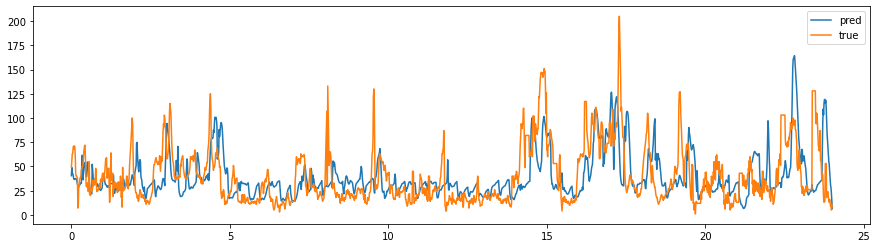

In [33]:
t = np.linspace(0,24,1752)
plt.figure(figsize = (15, 4))
plt.plot(t, y_pred,label = 'pred')
plt.plot(t, y_true,label = 'true')
plt.legend()

In [34]:
# BiLSTM
unit_n = 128
input_dim = len(SELECTED_PARAMETERS)
output_dim = 1
patience = 50
epoch_num = 400
batch_size = 64
verbose_num = 1

model = Sequential()
model.add(Bidirectional(LSTM(
    unit_n, return_sequences=True, stateful=False, input_shape=(TIMESTEPS_IN_SLICE, input_dim), activation='softsign'
)))
model.add(Bidirectional(LSTM(unit_n, return_sequences=True, stateful=False, activation='softsign')))
model.add(Bidirectional(LSTM(unit_n, return_sequences=True, stateful=False, activation='softsign')))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(output_dim)))

model.compile(loss='mean_squared_error', optimizer='RMSProp', metrics=['mae', 'acc'])
ES = [EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='auto')]
model.fit(train_X, train_Y,
          validation_data=(val_X, val_Y),
          epochs=epoch_num,
          batch_size=batch_size,
          verbose=verbose_num,
          shuffle=True,
          callbacks=ES)

# model_save_path = os.path.join(mkDir(save_path_1), save_path_1_1)
# model.save(model_save_path)

Epoch 1/400
4/4 [==============================] - 1s 218ms/step - loss: 0.9452 - mae: 0.6969 - acc: 0.0000e+00 - val_loss: 0.4288 - val_mae: 0.5165 - val_acc: 0.0000e+00
Epoch 2/400
4/4 [==============================] - 0s 70ms/step - loss: 0.7883 - mae: 0.6331 - acc: 0.0000e+00 - val_loss: 0.4401 - val_mae: 0.5368 - val_acc: 0.0000e+00
Epoch 3/400
4/4 [==============================] - 0s 73ms/step - loss: 0.7661 - mae: 0.6351 - acc: 0.0000e+00 - val_loss: 0.3694 - val_mae: 0.4566 - val_acc: 0.0000e+00
Epoch 4/400
4/4 [==============================] - 0s 70ms/step - loss: 0.7423 - mae: 0.6118 - acc: 0.0000e+00 - val_loss: 0.5039 - val_mae: 0.6018 - val_acc: 0.0000e+00
Epoch 5/400
4/4 [==============================] - 0s 70ms/step - loss: 0.7063 - mae: 0.6047 - acc: 0.0000e+00 - val_loss: 0.5044 - val_mae: 0.5970 - val_acc: 0.0000e+00
Epoch 6/400
4/4 [==============================] - 0s 71ms/step - loss: 0.8110 - mae: 0.6513 - acc: 0.0000e+00 - val_loss: 0.3854 - val_mae: 0.4878 -

Epoch 49/400
4/4 [==============================] - 0s 73ms/step - loss: 0.5834 - mae: 0.5505 - acc: 0.0000e+00 - val_loss: 0.3530 - val_mae: 0.4102 - val_acc: 0.0000e+00
Epoch 50/400
4/4 [==============================] - 0s 70ms/step - loss: 0.4836 - mae: 0.4963 - acc: 0.0000e+00 - val_loss: 0.5521 - val_mae: 0.5943 - val_acc: 0.0000e+00
Epoch 51/400
4/4 [==============================] - 0s 73ms/step - loss: 0.4767 - mae: 0.5049 - acc: 0.0000e+00 - val_loss: 0.3872 - val_mae: 0.4368 - val_acc: 0.0000e+00
Epoch 52/400
4/4 [==============================] - 0s 71ms/step - loss: 0.4895 - mae: 0.5029 - acc: 0.0000e+00 - val_loss: 0.4064 - val_mae: 0.4783 - val_acc: 0.0000e+00
Epoch 53/400
4/4 [==============================] - 0s 73ms/step - loss: 0.5008 - mae: 0.5076 - acc: 0.0000e+00 - val_loss: 0.3956 - val_mae: 0.4900 - val_acc: 0.0000e+00
Epoch 54/400
4/4 [==============================] - 0s 73ms/step - loss: 0.4775 - mae: 0.5044 - acc: 0.0000e+00 - val_loss: 0.3414 - val_mae: 0.4

In [35]:
test_Y_predict = model.predict(test_X, batch_size=batch_size)

y_true = all_Y_PM25_scaler.inverse_transform(test_Y.reshape((-1, 1), order='C'))
y_pred = all_Y_PM25_scaler.inverse_transform(test_Y_predict.reshape((-1, 1), order='C'))
evaluate_all_time_step(y_true, y_pred, [RMSE, MAE, r])

When timestep =   1 hours, the RMSE   is   19.376 |  the MAE    is   13.176 |  the r      is    0.740 | 
When timestep =   2 hours, the RMSE   is   22.441 |  the MAE    is   14.727 |  the r      is    0.663 | 
When timestep =   4 hours, the RMSE   is   24.140 |  the MAE    is   15.634 |  the r      is    0.587 | 
When timestep =   8 hours, the RMSE   is   26.663 |  the MAE    is   17.342 |  the r      is    0.539 | 
When timestep =  12 hours, the RMSE   is   27.715 |  the MAE    is   18.273 |  the r      is    0.516 | 
When timestep =  24 hours, the RMSE   is   26.664 |  the MAE    is   18.257 |  the r      is    0.464 | 


In [36]:
y_pred

array([[30.4435  ],
       [31.04154 ],
       [31.586895],
       ...,
       [33.775482],
       [34.698627],
       [35.5184  ]], dtype=float32)

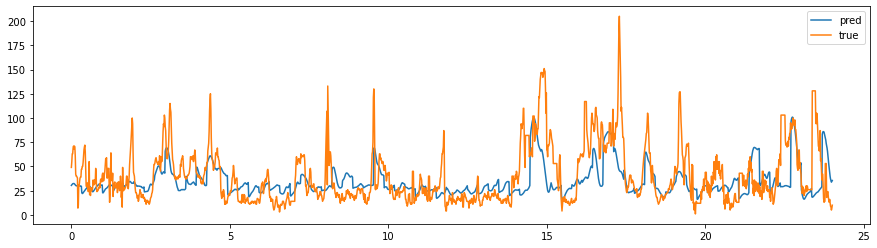

In [37]:
t = np.linspace(0,24,1752)
plt.figure(figsize = (15, 4))
plt.plot(t, y_pred,label = 'pred')
plt.plot(t, y_true,label = 'true')
plt.legend()